# Analysis Lab Notebook for the Final Model

This notebook contains the analysis for the final model trained with the best hyperparameters. This is a 'lab' notebook, and hence it is meant as as a walkthrough of the exploration process.

## Load Libraries

In [1]:
import pickle
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Import utility functions defined in ../common/ package
import sys
sys.path.append('../')
from common import *

2023-05-01 16:08:46.653030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 16:08:46.748475: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-01 16:08:46.751142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-01 16:08:46.751155: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Load Raw Data for Analysis

In [2]:
data_file_path: str = 'final-model-raw-data.pickle'

# Load Data from the K-Fold Evaluation of the Final Model
with open(data_file_path, 'rb') as handle:
    final_model_kfold = pickle.load(handle)
    print("Loaded Kfold History Data for Final Model")
    print(f"Found K = {len(final_model_kfold)} folds.")

Loaded Kfold History Data for Final Model
Found K = 10 folds.


## Utility Functions for Analysis

In [3]:
def to_csv(kfold_metrics_list, filename: str, metric: str = 'val_auc', header: bool = True) -> None:
    folds : int = len(kfold_metrics_list)
    epochs: int = len(kfold_metrics_list[0]['val_auc'])

    with open(filename, 'w') as csvfile:
        
        writer = csv.writer(csvfile)

        if header:
            header: list = ["epochs"] + [f"fold{x+1}" for x in range(folds)] + ['avg']
            writer.writerow(header)

        for epoch in range(epochs):
            values_per_epoch: list[float] = [x[metric][epoch] for x in kfold_metrics_list]
            mean_per_epoch  : float = sum(values_per_epoch) / folds

            csv_row_list: list[float] = [epoch + 1] + values_per_epoch + [mean_per_epoch]

            writer.writerow(csv_row_list)

# Analysis Code

Let's begin by quickly previewing the k-fold history files from our final model:

In [4]:
for item in final_model_kfold:
    print(item)

{'loss': [0.6753668189048767, 0.39617353677749634, 0.35916271805763245, 0.33245357871055603, 0.3215218186378479, 0.3140741288661957, 0.3034232258796692, 0.29385215044021606, 0.28749293088912964, 0.28077030181884766, 0.2707480788230896, 0.26546597480773926, 0.2621886730194092, 0.25835177302360535, 0.2502292990684509, 0.24697084724903107, 0.24153564870357513, 0.2445618063211441, 0.24255476891994476, 0.24128876626491547, 0.2525882124900818, 0.25396499037742615, 0.24885296821594238, 0.24085591733455658, 0.24046824872493744, 0.2312392145395279, 0.23159357905387878, 0.23431436717510223, 0.23394392430782318, 0.2416173666715622, 0.232209250330925, 0.23589935898780823, 0.24081078171730042, 0.24924823641777039, 0.25341010093688965, 0.25232723355293274, 0.23674376308918, 0.24840734899044037, 0.27300721406936646, 0.26109394431114197], 'auc': [0.505636990070343, 0.541519045829773, 0.6269522309303284, 0.6968084573745728, 0.7150847911834717, 0.7365492582321167, 0.7625995874404907, 0.7805185317993164,

## Graph K-Fold Validation Data

Now we want to plot the average k-fold performance of our final model

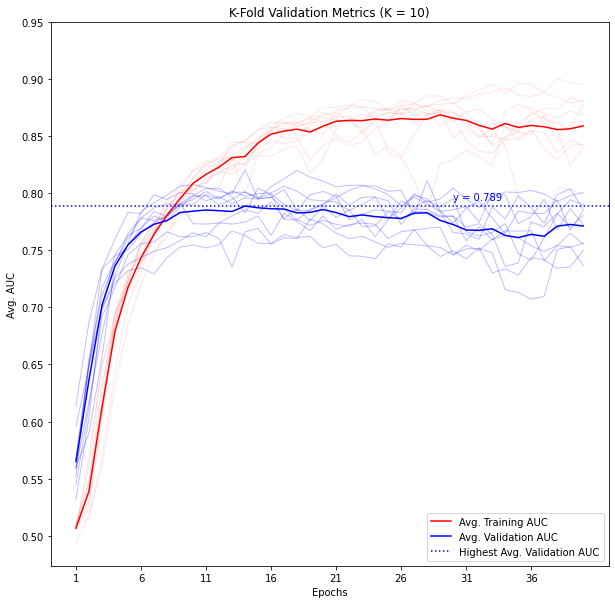

In [5]:
plot_kfold_history(final_model_kfold, x_axis_max=40)

## Export K-Fold Validation Data as CSV

The next step is to export the k-fold validation data of the final model into a CSV file, which we can conveniently process in other programs (like LaTeX).

Note that the CSV format is as follows:

```
epochs,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10,avg
```

In [6]:
# data_file_path defined at the start of the document

metric: str = "auc"
filename_csv: str = "kfold_final_model_train_auc.csv"
with open(data_file_path, 'rb') as handle:
    kfold_pickle = pickle.load(handle)
    to_csv(kfold_pickle, filename_csv, metric=metric)

metric: str = "val_auc"
filename_csv: str = "kfold_final_model_valid_auc.csv"
with open(data_file_path, 'rb') as handle:
    kfold_pickle = pickle.load(handle)
    to_csv(kfold_pickle, filename_csv, metric=metric)

# Find the Best Performing Model out of the K-Folds

For our final model that is trained on the hyperparameters, we want to find the specific instance out of the 10 models that we trained, which performs the best. We can do this by finding the max observed validation AUC in each k-fold model, and finding the specific fold which performed the best:

In [7]:
print("Fold    Max Val. AUC")
for fold, kfold_history in enumerate(final_model_kfold):
    max_observed_val_auc: float = max(kfold_history['val_auc'])
    
    print(f"{fold + 1}/{len(final_model_kfold)}:   {round(max_observed_val_auc, 3)}")

Fold    Max Val. AUC
1/10:   0.768
2/10:   0.806
3/10:   0.783
4/10:   0.777
5/10:   0.801
6/10:   0.802
7/10:   0.821
8/10:   0.811
9/10:   0.805
10/10:   0.793


Model kfold 7 has the best performing validation AUC at $0.821$. We'll use the weights from this model going on forwards for our final evaluation. Note that the higher performance may be due to the particularities of the folded dataset itself- or it could be due to a different random initialisation.

# Graphing the Best Performing Model

In [8]:
# Note: fold 7 = 6 with zero indexing.
best_performing_model = final_model_kfold[6]

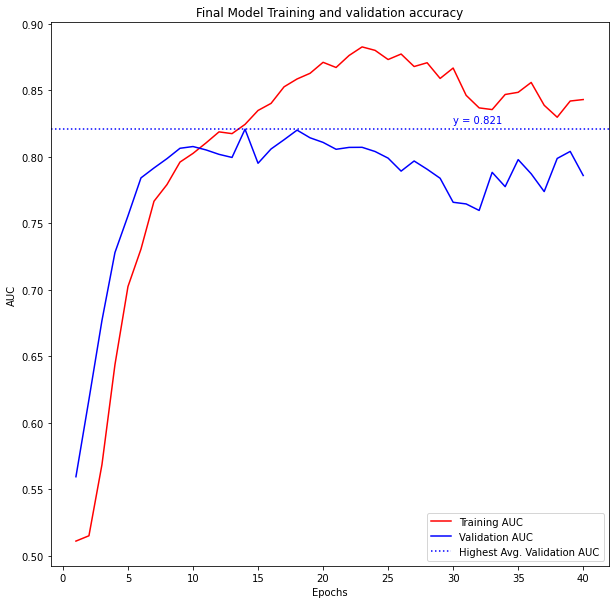

In [9]:
metric = best_performing_model['auc']
val_metric = best_performing_model['val_auc']
epochs = range(1, len(metric) + 1)

fig = plt.figure(figsize=(10,10))
plt.plot(epochs, metric, 'r', label='Training AUC')
plt.plot(epochs, val_metric, 'b', label='Validation AUC')
plt.axhline(y=max(val_metric), c='b', label='Highest Avg. Validation AUC', linestyle="dotted")
plt.text(40 - 10, max(val_metric) + 0.005,f"y = {round(max(val_metric), 3)}", c="b")

plt.title(f'Final Model Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.show()

# Saving the best performing model history

Finally, we save the data used to graph the above graph as a CSV file, so we may replicate it in LaTeX or other programs. We'll do this with a quick one-off call to `csvwriter`:

## Write data for training auc:

In [11]:
with open('final_model_train_auc.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)

    header: list[str] = ["epochs", "train_auc"]
    writer.writerow(header)

    for epoch, metric in enumerate(best_performing_model["auc"]):
        # epochs + 1 to convert zero-indexed to one-indexed.
        writer.writerow([str(epoch + 1), metric])



## Write data for validation auc:

In [12]:
with open('final_model_valid_auc.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)

    header: list[str] = ["epochs", "valid_auc"]
    writer.writerow(header)

    for epoch, metric in enumerate(best_performing_model["val_auc"]):
        # epochs + 1 to convert zero-indexed to one-indexed.
        writer.writerow([str(epoch + 1), metric])